# Curso: Modelos preditivos em dados: detecção de fraude

Objetivos:
* Modelos preditivos em dados: detecção de fraude
* Entenda como importar e preparar seus dados;
* Aplique a análise exploratória de dados (AED) de forma eficiente;
* Crie modelos preditivos usando diferentes algoritmos;
* Compare o resultado de diferentes algoritmos de uma maneira válida usando as métricas de performance;
* Aprenda como apresentar os resultados de forma eficiente para toda a sua empresa;
* Resolva um problema real com dados reais.

## Importanod as bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from scipy import special
import itertools
from datetime import timedelta
from IPython.display import display
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Importando os dados

In [116]:
fraude_df = pd.read_csv('datasets/Fraud_Data.csv', header=0)
ISP_df = pd.read_csv('datasets/IpAddress_to_Country.csv')

## Explorando os dados

In [117]:
fraude_df.shape

(151112, 11)

In [118]:
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [119]:
fraude_df.dtypes

id                  int64
cadastro           object
compra             object
valor               int64
id_dispositivo     object
fonte              object
browser            object
genero             object
idade               int64
ip                float64
fraude              int64
dtype: object

In [120]:
for col in fraude_df.columns:
    print(f'O número de valores nulos na coluna {col}: {fraude_df[col].isna().sum()}')

O número de valores nulos na coluna id: 0
O número de valores nulos na coluna cadastro: 0
O número de valores nulos na coluna compra: 0
O número de valores nulos na coluna valor: 0
O número de valores nulos na coluna id_dispositivo: 0
O número de valores nulos na coluna fonte: 0
O número de valores nulos na coluna browser: 0
O número de valores nulos na coluna genero: 0
O número de valores nulos na coluna idade: 0
O número de valores nulos na coluna ip: 0
O número de valores nulos na coluna fraude: 0


In [121]:
fraude_df .describe()

,id,valor,idade,ip,fraude
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [122]:
for col in ISP_df.columns:
    print(f'{col}: {ISP_df[col].dtype}')

limite_inferior_ip: float64
limite_superior_ip: int64
pais: object


In [123]:
ip_floats = ISP_df.limite_inferior_ip.apply(lambda x: not x.is_integer()).sum()
print(f'Número de limites inferiores de endereço de IP com decimal não-zero: {ip_floats}')

Número de limites inferiores de endereço de IP com decimal não-zero: 0


In [124]:
ISP_df.limite_superior_ip = ISP_df.limite_superior_ip.astype(np.float64)

In [126]:
ISP_df.dtypes

limite_inferior_ip    float64
limite_superior_ip    float64
pais                   object
dtype: object

In [127]:
for col in ISP_df.columns:
    print(f'O número de valores nulos na coluna {col}: {ISP_df[col].isna().sum()}')

O número de valores nulos na coluna limite_inferior_ip: 0
O número de valores nulos na coluna limite_superior_ip: 0
O número de valores nulos na coluna pais: 0


In [128]:
ISP_df.describe()

,limite_inferior_ip,limite_superior_ip
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [129]:
display(ISP_df[ISP_df['limite_inferior_ip'] == ISP_df['limite_inferior_ip'].max()])
display(ISP_df[ISP_df['limite_superior_ip'] == ISP_df['limite_superior_ip'].max()])

,limite_inferior_ip,limite_superior_ip,pais
138845,3.758096e+09,3.758096e+09,Australia


,limite_inferior_ip,limite_superior_ip,pais
138845,3.758096e+09,3.758096e+09,Australia


In [130]:
def isp_counts(isp):
    pais = ISP_df[(ISP_df.limite_inferior_ip <= isp) & (ISP_df.limite_superior_ip >= isp)].pais
    if pais.shape[0] == 1:
        print('Único')
        return 'Único'
    elif pais.shape[0] > 1:
        return 'varios países'
    else:
        if isp > ISP_df.limite_superior_ip.max():
            return 'Muito grande'
        elif isp > ISP_df.limite_inferior_ip.min():
            return 'Muito pequeno'
        else:
            return 'Faltando'
        
ip_counts = fraude_df.ip.apply(isp_counts)

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Únic

Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único
Único


In [135]:
ip_counts.value_counts()

Único            129146
Muito grande      19383
Muito pequeno      1949
Faltando            634
Name: ip, dtype: int64

In [136]:
def ip_para_pais(ip):
    tmp = ISP_df[(ISP_df.limite_inferior_ip <= ip)
            & (ISP_df.limite_superior_ip >= ip)].pais
    if tmp.shape[0] == 1:
        return tmp.iloc[0]
    elif tmp.shape[0] < 1:
        return print("Faltando")
    elif tmp.shape[0] > 1:
        return print("Erro")

fraude_df["pais"] = fraude_df.ip.apply(ip_para_pais)

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
Faltando
F

In [137]:
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [138]:
fraude_df.to_csv('datasets/Dados_fraude_com_pais', index=False)

In [264]:
fraude_df = pd.read_csv('datasets/Dados_fraude_com_pais')
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [265]:
fraude_df.pais.value_counts()

United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
                     ...  
Myanmar                  1
Vanuatu                  1
Dominica                 1
Niger                    1
Guadeloupe               1
Name: pais, Length: 181, dtype: int64

In [90]:
fraude_df = pd.read_csv('datasets/Dados_fraude_com_pais')
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## EDA

In [91]:
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [92]:
fraude_df.fraude.value_counts(normalize=True)

0    0.906354
1    0.093646
Name: fraude, dtype: float64

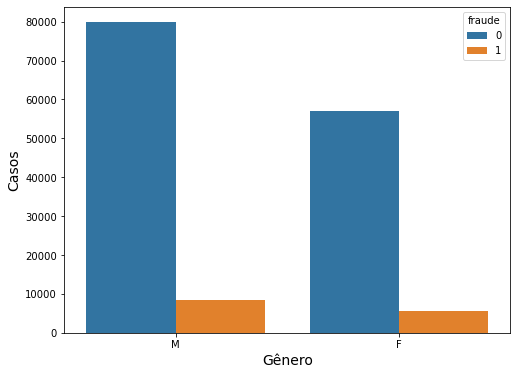

In [93]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='genero', hue='fraude', data=fraude_df, ax=ax)
ax.set_xlabel('Gênero', fontsize=14)
ax.set_ylabel('Casos', fontsize=14)
plt.show()

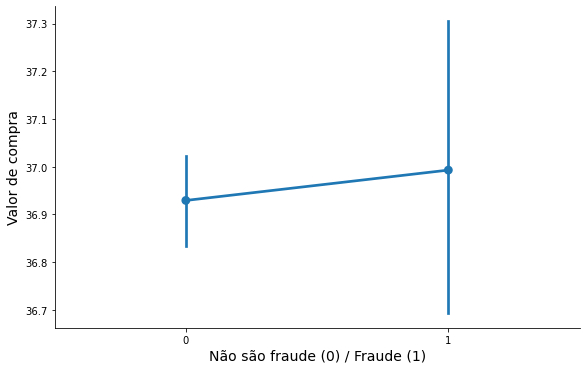

In [94]:
ax = sns.catplot(x='fraude', y='valor', data=fraude_df, aspect=1.6, kind='point')
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Valor de compra', fontsize=14)
plt.show()

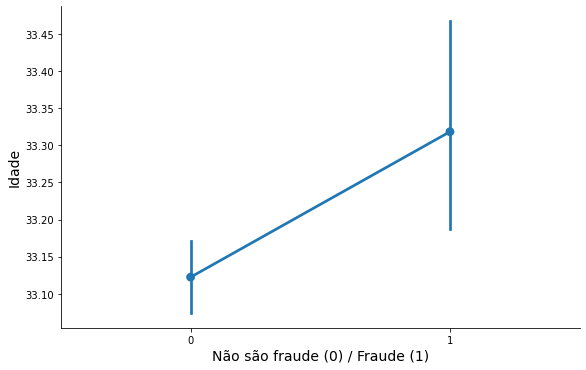

In [95]:
ax = sns.catplot(x='fraude', y='idade', data=fraude_df, aspect=1.6, kind='point')
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Idade', fontsize=14)
plt.show()

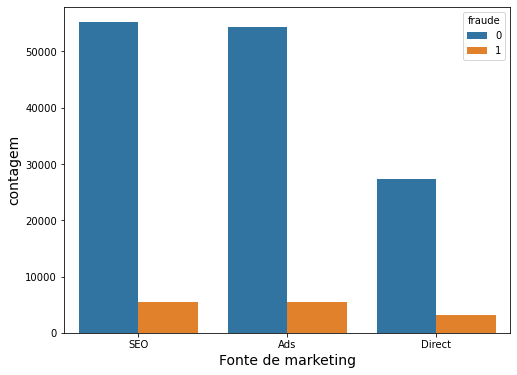

In [96]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x='fonte', hue='fraude', data=fraude_df, ax=ax)
ax.set_xlabel('Fonte de marketing', fontsize=14)
ax.set_ylabel('contagem', fontsize=14)
plt.show()

In [97]:
sums_f = fraude_df[fraude_df.fraude == 1]['fraude'].groupby(fraude_df['pais']).count()
sums_f= sums_f.to_frame().reset_index()

sums_nf = fraude_df[fraude_df.fraude == 0]['fraude'].groupby(fraude_df['pais']).count()
sums_nf = sums_nf.to_frame().reset_index()

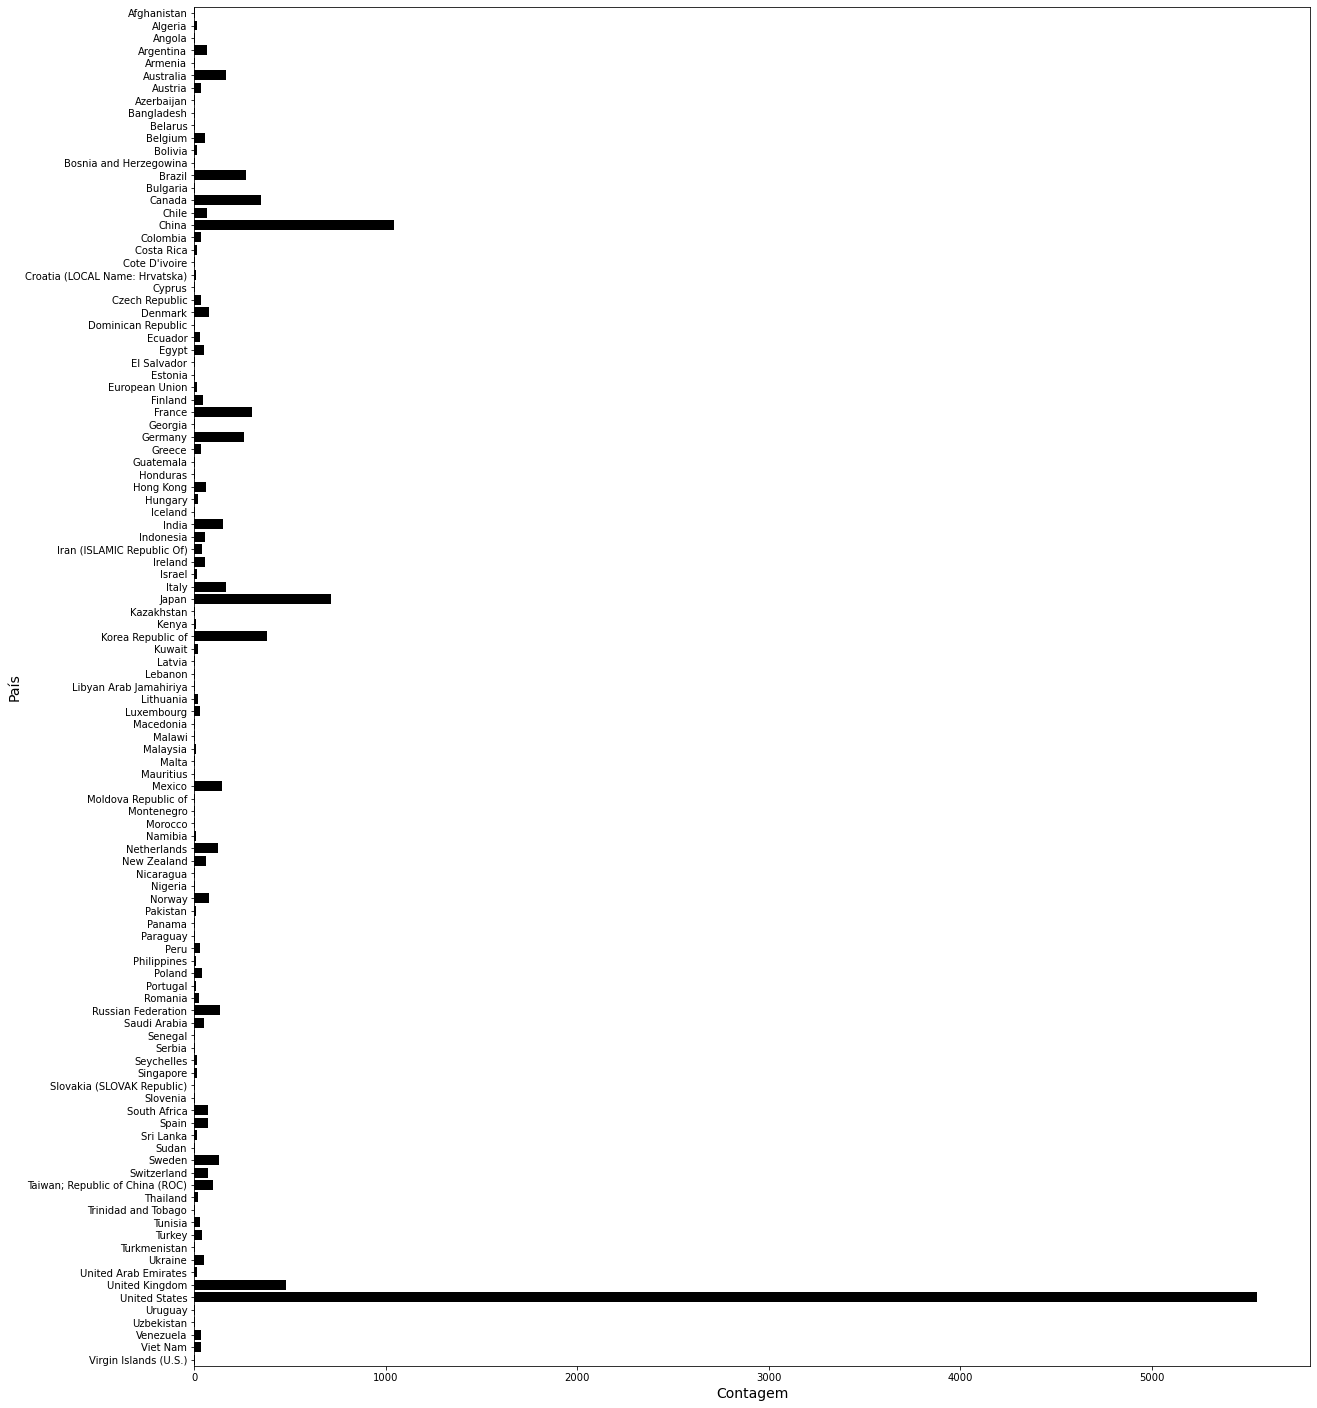

In [98]:
fig, ax = plt.subplots(figsize=(20,25))
sns.set_color_codes('muted')
sns.barplot(x='fraude', y='pais', data=sums_f,
            label='Total', color='black')
ax.set_xlabel('Contagem', fontsize=14)
ax.set_ylabel('País', fontsize=14)
plt.show()

In [99]:
tmp_df = pd.DataFrame(columns=['fraude', 'id_por_dispositivo', 'id_por_ip'])
tmp_df['fraude'] = fraude_df['fraude']

userid_count = fraude_df.groupby('id_dispositivo').id.count()
tmp_df['id_por_dispositivo'] = fraude_df.id_dispositivo.apply(lambda x: userid_count[x])

userid_count2 = fraude_df.groupby('ip').id.count()
tmp_df['id_por_ip'] = fraude_df.ip.apply(lambda x: userid_count2[x])

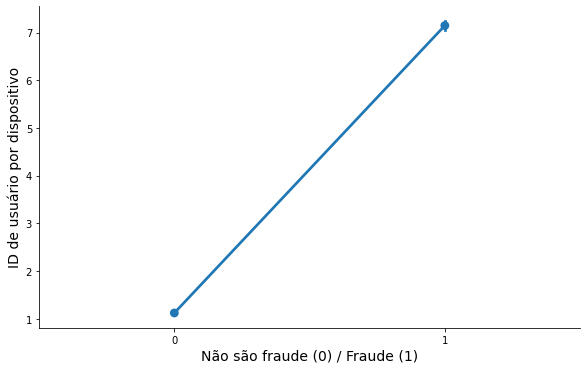

In [100]:
ax = sns.catplot(x='fraude', y='id_por_dispositivo', data=tmp_df, aspect=1.6, kind='point')
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('ID de usuário por dispositivo', fontsize=14)
plt.show()

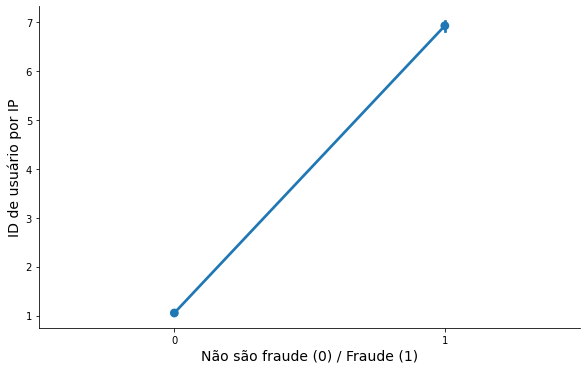

In [101]:
ax = sns.catplot(x='fraude', y='id_por_ip', data=tmp_df, aspect=1.6, kind='point')
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('ID de usuário por IP', fontsize=14)
plt.show()

In [102]:
tmp_df['cadastro'] = pd.to_datetime(fraude_df['cadastro'])
tmp_df['compra'] = pd.to_datetime(fraude_df['compra'])

tmp_df['tempo'] = (tmp_df['compra'] - tmp_df['cadastro']).apply(lambda x: x.seconds)

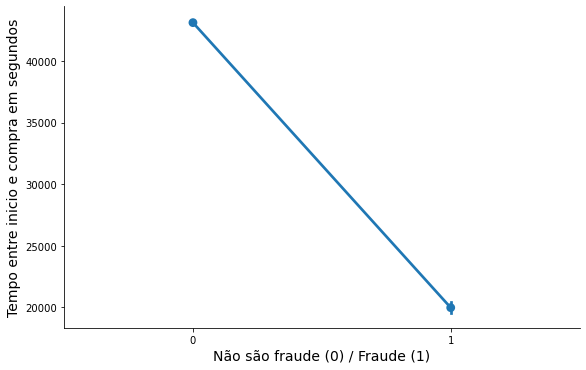

In [103]:
ax = sns.catplot(x='fraude', y='tempo', data=tmp_df, aspect=1.6, kind='point')
plt.xlabel('Não são fraude (0) / Fraude (1)', fontsize=14)
plt.ylabel('Tempo entre inicio e compra em segundos', fontsize=14)
plt.show()

In [104]:
tmp_df.head()

,fraude,id_por_dispositivo,id_por_ip,cadastro,compra,tempo
0,0,1,1,2015-02-24 22:55:49,2015-04-18 02:47:11,13882
1,0,1,1,2015-06-07 20:39:50,2015-06-08 01:38:54,17944
2,1,12,12,2015-01-01 18:52:44,2015-01-01 18:52:45,1
3,0,1,1,2015-04-28 21:13:25,2015-05-04 13:54:50,60085
4,0,1,1,2015-07-21 07:09:52,2015-09-09 18:40:53,41461


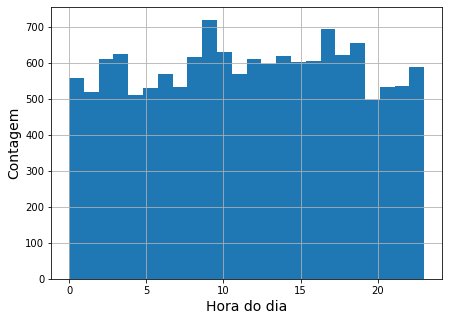

In [105]:
fig, ax = plt.subplots(figsize=(7,5))
ax = tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.hour).hist(bins=24)
ax.set_xlabel('Hora do dia', fontsize=14)
ax.set_ylabel('Contagem', fontsize=14)
plt.show()

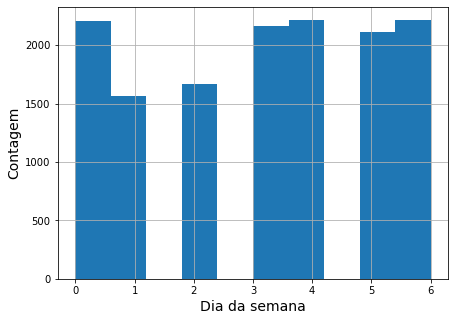

In [106]:
fig, ax = plt.subplots(figsize=(7,5))
ax = tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.dayofweek).hist()
ax.set_xlabel('Dia da semana', fontsize=14)
ax.set_ylabel('Contagem', fontsize=14)
plt.show()

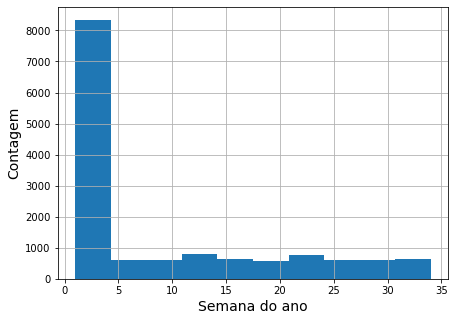

In [107]:
fig, ax = plt.subplots(figsize=(7,5))
ax = tmp_df[tmp_df['fraude'] == 1].cadastro.apply(lambda x: x.week).hist()
ax.set_xlabel('Semana do ano', fontsize=14)
ax.set_ylabel('Contagem', fontsize=14)
plt.show()

In [108]:
userid_count3 = fraude_df.groupby('id_dispositivo').id.count()
fraude_df['id_por_dispositivo'] = fraude_df.id_dispositivo.apply(lambda x: userid_count3[x])

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1


In [109]:
userid_count4 = fraude_df.groupby('ip').id.count()
fraude_df['id_por_ip'] = fraude_df.ip.apply(lambda x: userid_count4[x])

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1


In [110]:
fraude_df['media_id'] = (fraude_df.id_por_dispositivo + fraude_df.id_por_ip)/2

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0


In [111]:
fraude_df['cadastro'] = pd.to_datetime(fraude_df['cadastro'])
fraude_df['compra'] = pd.to_datetime(fraude_df['compra'])

fraude_df['tempo'] = (fraude_df['compra'] - fraude_df['cadastro']).apply(lambda x: x.seconds)

fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,fraude,pais,id_por_dispositivo,id_por_ip,media_id,tempo
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,1.0,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,1.0,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,12,12,12.0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN,1,1,1.0,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,1,1,1.0,41461


In [112]:
pais_dummies = pd.get_dummies(fraude_df['pais'], prefix='pais')
fraude_df = pd.concat([fraude_df, pais_dummies], axis=1)
fraude_df.head()

,id,cadastro,compra,valor,id_dispositivo,fonte,browser,genero,idade,ip,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,...,1,0,0,0,0,0,0,0,0,0


In [113]:
fraude_df.drop(['id', 'cadastro', 'compra', 'genero', 'id_dispositivo', 'ip', 'id_por_dispositivo',
                'id_por_ip', 'pais', 'fonte', 'browser', 'idade', 'valor'], axis=1, inplace=True)

In [114]:
fraude_df.head()

,fraude,media_id,tempo,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0,1.0,13882,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.0,17944,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,12.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1.0,60085,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,41461,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


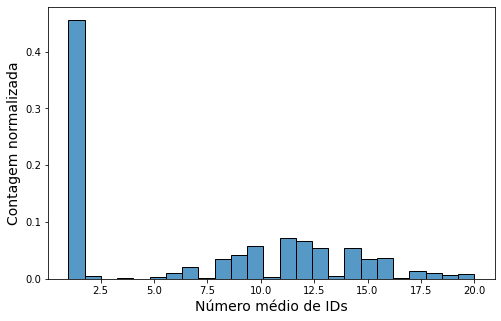

In [115]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.histplot(data=fraude_df[fraude_df['fraude'] == 1], x='media_id', stat='probability', bins=25)
ax.set_xlabel('Número médio de IDs', fontsize=14)
ax.set_ylabel('Contagem normalizada', fontsize=14)
plt.show()

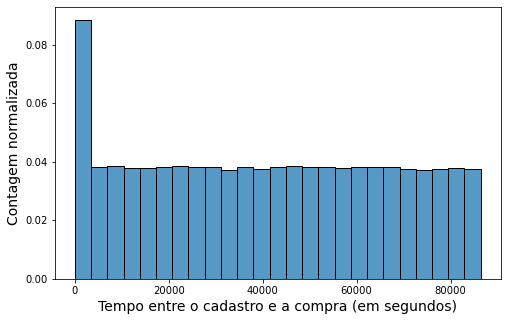

In [116]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.histplot(data=fraude_df, x='tempo', stat='probability', bins=25)
ax.set_xlabel('Tempo entre o cadastro e a compra (em segundos)', fontsize=14)
ax.set_ylabel('Contagem normalizada', fontsize=14)
plt.show()

## Escalando os dados

### Para transformar a distribuição acima, em uma distribuição gaussiana, irei aplicar a transformação sugerida por  Murray Rosenblatt no paper "Remarks on a Multivariate Transformation", utilizada em distribuições uniformemente distribuida

In [117]:
def rescale_series(series):
    series_min = series.min() - 1e-5
    series_max = series.max() + 1e-5
    new_series = (series - series_min) / (series_max - series_min)
    new_series = new_series.apply(lambda x: np.sqrt(2) * special.erfinv(2 * x - 1))
    return new_series

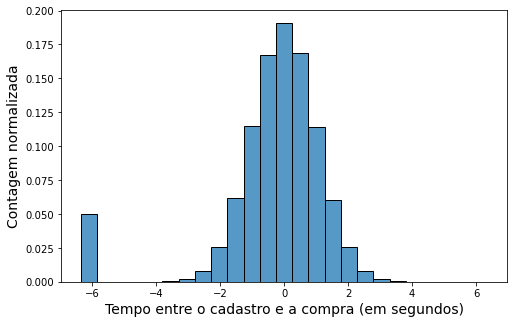

In [118]:
fraude_df['tempo'] = rescale_series(fraude_df['tempo'])
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.histplot(data=fraude_df, x='tempo', stat='probability', bins=25)
ax.set_xlabel('Tempo entre o cadastro e a compra (em segundos)', fontsize=14)
ax.set_ylabel('Contagem normalizada', fontsize=14)
plt.show()

In [119]:
def rescale_series(series):
    series_min = series.min()
    series_max = series.max()
    new_series = (series - series_min) / (series_max - series_min)
    return new_series

In [120]:
onehotencoded = [feature for feature in fraude_df.columns if "pais" not in feature and feature != "fraude"]
onehotencoded

for col in onehotencoded:
    fraude_df[col] = rescale_series(fraude_df[col])

In [122]:
fraude_df.to_csv('datasets/Dados_fraude_scaled', index=False)

## Selecionando as melhores features

In [3]:
fraude_df = pd.read_csv('datasets/Dados_fraude_scaled')
fraude_df.head()

,fraude,media_id,tempo,pais_Afghanistan,pais_Albania,pais_Algeria,pais_Angola,pais_Antigua and Barbuda,pais_Argentina,pais_Armenia,...,pais_United States,pais_Uruguay,pais_Uzbekistan,pais_Vanuatu,pais_Venezuela,pais_Viet Nam,pais_Virgin Islands (U.S.),pais_Yemen,pais_Zambia,pais_Zimbabwe
0,0,0.000000,0.421773,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.000000,0.435753,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0.578947,0.000000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0.000000,0.540331,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.000000,0.496019,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
X = fraude_df.drop('fraude', axis=1)
y = fraude_df['fraude']

In [5]:
clf = ExtraTreesClassifier()
clf.fit(X, y)

features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_

features[features['importance'] >= features.importance.mean()].sort_values(by='importance', ascending=False)

,feature,importance
1,tempo,0.690285
0,media_id,0.304434


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

y_train = y_train.apply(lambda x: -1 if x == 1 else 1)
y_test = y_test.apply(lambda x: -1 if x == 1 else 1)

In [7]:
IF = IsolationForest(max_samples='auto', contamination=0.095, random_state=1)
param_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500]}

clf = GridSearchCV(IF, 
                   param_grid, 
                   scoring='f1', 
                   n_jobs=10, 
                   cv=5,
                   verbose=10)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=IsolationForest(contamination=0.095, random_state=1),
             n_jobs=10,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500]},
             scoring='f1', verbose=10)

              precision    recall  f1-score   support

      Fraude       0.48      0.48      0.48      3546
      Normal       0.95      0.95      0.95     34232

    accuracy                           0.90     37778
   macro avg       0.71      0.71      0.71     37778
weighted avg       0.90      0.90      0.90     37778

A área sobre a curva é: 0.712


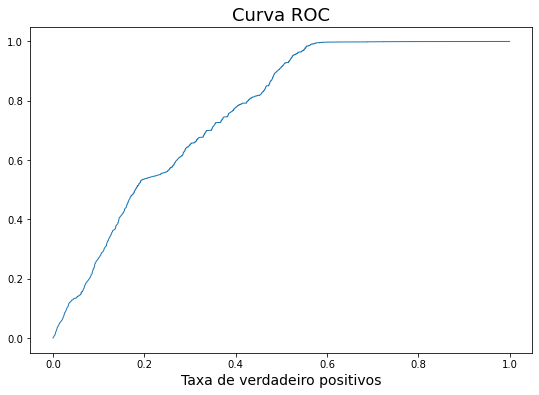

In [8]:
clf_best = clf.best_estimator_
y_pred = clf_best.predict(X_test)
decision_function = clf_best.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print(classification_report(y_test, y_pred,
                            target_names=['Fraude', 'Normal']))

print(f'A área sobre a curva é: {roc_auc:0.3f}')

fpr, tpr, thresholds = roc_curve(y_test, decision_function)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(fpr, tpr, lw=1)
ax.set_xlabel("Taxa de falsos positivos", fontsize=14)
ax.set_xlabel("Taxa de verdadeiro positivos", fontsize=14)
ax.set_title('Curva ROC', fontsize=18)
plt.show()                      

In [9]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[ 1694  1852]
 [ 1872 32360]]


In [14]:
X['fraude'] = y

X_anomalias = X[X['fraude'] == 1]
X_normal = X[X['fraude'] == 0]

X_train = X_normal.sample(frac=0.7)
X_test = X_normal.drop(X_train.index)

X_test = pd.concat([X_test, X_anomalias], axis=0)

X_train = X_train.sample(frac=1).reset_index()
X_test = X_test.sample(frac=1).reset_index()

y_test = X_test['fraude']
X_test = X_test.drop('fraude', axis=1)

X_cv, X_eval, y_cv, y_eval = train_test_split(X_test, y_test, test_size=0.3, random_state=23)

y_cv = y_cv.apply(lambda x: 1 if x==0 else -1)
y_eval = y_eval.apply(lambda x: 1 if x==0 else -1)

X_train = X_train.drop('fraude', axis=1)

In [15]:
param_grid = {"nu": np.linspace(0.001, 0.01, 5), "gamma": [0.01, 0.03, 0.1, 0.3]}

param_list = list(itertools.product(param_grid["nu"],param_grid["gamma"]))

In [23]:
def random_gridsearch(param_list, n_sample, X_train, X_cv, y_cv):

    np.random.seed(1)
    f1_max = 0
    param_list = random.sample(param_list, n_sample)
    remaining_fits = n_sample
    for params in param_list:
        nu, gamma = params
        OCSVM = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma,)
        print('Fitando modelo...')
        OCSVM.fit(X_train)

        cv_preds = OCSVM.predict(X_cv)
        f1 = f1_score(y_cv.values, cv_preds, average="binary")

        if f1 > f1_max:
            f1_max = f1
            OCSVM_best = OCSVM

            remaining_fits -=1

    return f1_max, OCSVM

f1_max, OCSVM_best = random_gridsearch(param_list, 10, X_train, X_cv, y_cv)

Fitando modelo...


KeyboardInterrupt: 

In [ ]:
OCSVM_best.fit(X_train)
y_pred = OSCVM_best.predict(X_eval)
roc_auc = roc_auc_score(y_eval, y_pred)

print(classification_report(y_eval,
                            y_pred,
                            target_names=['anormais', 'normais']))

print('Área sob a curva ROC: {:0.3f}', format(roc_auc))

OCSVM_probs = OCSVM_best.decision_function(X_eval)
fpr, tpr, threshold = roc_curve(y_eval, OCSVM_probs)

plt.plot(fpr, tpr, lw=1, label='ROC')
plt.plot([0,1], [0,1], '--', color=[0.6, 0.6, 0.6], label='sorte')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('Taxa de positivos falsos', fontsize=15)
plt.ylabel('Taxa de positivos verdadeiros', fontsize=15)
plt.title('Curva ROC')

plt.show()

In [ ]:
print(confusion_matrix(y_eval, y_pred))

In [ ]:
X_dev, X_eval, y_dev, y_eval = train_test_split(X, y, train_size = 0.75, random_state = 23)
y_dev = y_dev.apply(lambda x: 1 if x == 0 else -1)
y_eval = y_eval.apply(lambda x: 1 if x == 0 else -1)

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=1)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred)

cv_preds